In [62]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# reading the dataset and learning about it
def get_data():
    with open('names.txt', 'r') as f:
        names = f.read().splitlines()
    return names
    
words = get_data()
print("number of names:", len(words))
print("shortest name length: ", min(len(w) for w in words))
print("longest name length: ", max(len(w) for w in words))


number of names: 32033
shortest name length:  2
longest name length:  15


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Dataset

In [12]:
#build data-set
block_size = 4 # how many characters do we take to predict the next one
X, Y = [], []

for w in words[:5]:
    context = [0] * block_size

    print(w)
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', ch)
        context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
.... ---> e
...e ---> m
..em ---> m
.emm ---> a
emma ---> .
olivia
.... ---> o
...o ---> l
..ol ---> i
.oli ---> v
oliv ---> i
livi ---> a
ivia ---> .
ava
.... ---> a
...a ---> v
..av ---> a
.ava ---> .
isabella
.... ---> i
...i ---> s
..is ---> a
.isa ---> b
isab ---> e
sabe ---> l
abel ---> l
bell ---> a
ella ---> .
sophia
.... ---> s
...s ---> o
..so ---> p
.sop ---> h
soph ---> i
ophi ---> a
phia ---> .


In [13]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 4]), torch.int64, torch.Size([32]), torch.int64)

this is how we should build our datasets, we did this for the first 5 words to see the outputs, however for the full dataset we would define a function

In [41]:
def build_dataset(wordss, block_size = 4):
    
    X, Y = [], []

    for w in wordss:
        context = [0] * block_size

        #print(w)
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', ch)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) #we train on 80% of our data
n2 = int(0.9*len(words)) #the validation set is 10% of our data

block_size = 4
X, Y = build_dataset(words, block_size=block_size)
Xtr, Ytr = build_dataset(words[:n1], block_size=block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size=block_size)
Xte, Yte = build_dataset(words[n2:], block_size=block_size)

print('X train shape: ',Xtr.shape,'\t Y train shape: ', Ytr.shape)
print('X validation shape: ',Xdev.shape,'\t Y validation shape: ', Ydev.shape)
print('X test shape: ',Xte.shape,'\t\t Y test shape: ', Yte.shape)

X train shape:  torch.Size([182512, 4]) 	 Y train shape:  torch.Size([182512])
X validation shape:  torch.Size([22860, 4]) 	 Y validation shape:  torch.Size([22860])
X test shape:  torch.Size([22774, 4]) 		 Y test shape:  torch.Size([22774])


# First Layer

In [36]:
C = torch.randn((27, 2)) #our lookup table, 27 rows because we only have 27 possible characters and 2 columns
#basically what we do is initially embed each character as a random vector of length 2

In [37]:
C[5] == F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([True, True])

because these are equivalent, we could discard the second one and just directly index into C

In [38]:
C[torch.tensor([5, 6, 7, 8, 1])]

tensor([[ 0.6335,  0.7352],
        [ 0.1372, -2.1275],
        [ 0.5347, -1.0004],
        [-0.0695, -0.4490],
        [ 0.8596, -2.3019]])

as seen above, we can also index C with a tensor, so what we'll do is call C[X]

In [39]:
C[Xtr].shape

torch.Size([182424, 4, 2])

In [40]:
emb = C[X] # This is our first layer and the input to our hidden layer
emb.shape

torch.Size([228146, 4, 2])

# Hidden Layer

In [42]:
hl_size = block_size * 2 #because we made C a 27 * 2 matrix
W1 = torch.randn((hl_size, 100))
b1 = torch.randn(100)

In [43]:
h = torch.tanh(emb.view(-1, hl_size) @ W1 + b1)
#.view is just pointing to our data with the dimensions that we want

In [44]:
h.shape

torch.Size([228146, 100])

# Output Layer

In [45]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [46]:
logits = h @ W2 + b2

In [47]:
logits.shape

torch.Size([228146, 27])

In [50]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape, prob[0].sum()

(torch.Size([228146, 27]), tensor(1.0000))

In [51]:
loss = -prob[torch.arange(228146), Y].log().mean()
loss

tensor(18.5260)

this is the loss we want to minimize

# Respectable :)

so now we do the steps but on training dataset, witha validation and separate test datasets

In [52]:
Xtr.shape, Ytr.shape

(torch.Size([182512, 4]), torch.Size([182512]))

In [53]:
g = torch.Generator().manual_seed(2147483647)
c_dim = 10
h_size = block_size * c_dim
C = torch.randn((27, c_dim), generator=g)
W1 = torch.randn((h_size, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [54]:
sum(p.nelement() for p in parameters) # number of parameters in total

13897

In [55]:
for p in parameters:
  p.requires_grad = True

In [56]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [57]:
lri = []
lossi = []
stepi = []

In [61]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, h_size) @ W1 + b1) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Ytr[ix])
  '''
  instead of:
    counts = logits.exp()
    prob = counts / counts.sum(1, keepdims=True)
    loss = -prob[torch.arange(228146), Y].log().mean()
  
  we use F.cross_Entropy because this way is more efficient. it creates a kernel instead of creating separate matrices.
  also on the backward pass this is easier.
  
  '''
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

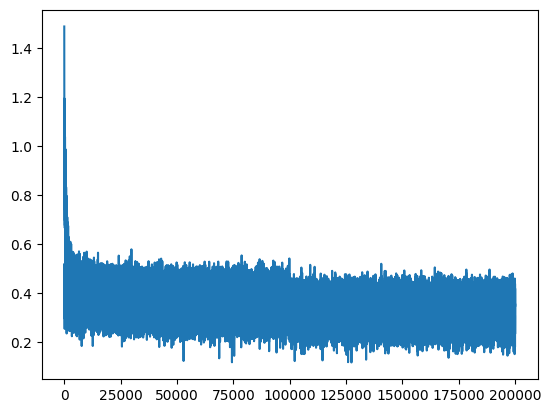

In [63]:
plt.plot(stepi, lossi)

In [64]:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1, h_size) @ W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1728, grad_fn=<NllLossBackward0>)

In [65]:
emb = C[Xte] 
h = torch.tanh(emb.view(-1, h_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1864, grad_fn=<NllLossBackward0>)

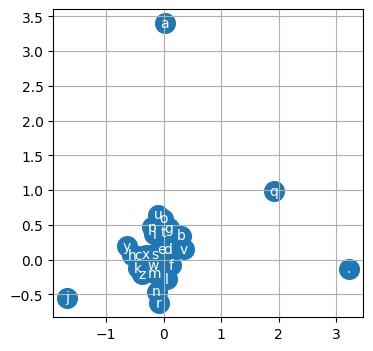

In [67]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(4,4))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# Sampling from the model

In [68]:
context = [0] * block_size

In [69]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

junide.
janavie.
pallay.
adin.
kaiin.
tolian.
juel.
kalinah.
zamilen.
asshedainrwie.
adsej.
inay.
artellaraua.
kyfon.
majanonis.
jahouan.
rhore.
yaezon.
kaevani.
werimiin.
